## Setup
Load all necessary libraries and doublecheck version of `tensorflow`.

In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
tf.__version__

'2.1.0'

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18, 6)
sns.set(style="whitegrid")

## Build Module

In [3]:
def filtered_train_image_names(height=256):
    """
    Filter out train image names from the train set directory with weird
    dimensions (wider than twice the height).
    """
    rows = []

    for dirname, _, filenames in os.walk(DIR+'train_set/train_set/'):
        for train_image_name in filenames:
            img = load_img(dirname + '/' + train_image_name)
            rows.append([train_image_name, img.width, img.height])

    df = pd.DataFrame(rows, columns=['image_name', 'width', 'height'])
    df = df[df['width'] <= height * 2]
    
    return list(df['image_name'].values)

In [4]:
# @TODO: not ported yet. used this in colab by writing directly back to disk.
def crop_centre_box(full_image_name, target_w=256, target_h=256):
    """
    Make sure images do not get resized to fit the target dimensions but instead 
    are cropped (and thus keep original ratio) to the desired dimensions 
    while maintaining the original centre.
    """
    img = load_img(full_image_name)
    w = img.width
    h = img.height
    
    left = (w - target_w) / 2
    upper = (h - target_h) / 2
    right = left + target_w
    lower = upper + target_h
    
    return img.crop((left, upper, right, lower))

In [5]:
def get_class_weights(map_labels_to_classes):
    """
    return a dictionary with class weights in case of imbalanced dataset
    https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights
    """
    labels = pd.read_csv(DIR + 'train_labels.csv')
    class_weights = (1 / labels['label'].value_counts()) * len(labels.index) / 2.0
    class_weights.index = class_weights.index.astype('str').map(map_labels_to_classes)
    return class_weights.to_dict()

In [6]:
def get_generator(df, shuffle=True, augmented=False):
    if augmented:
        datagen = ImageDataGenerator(
            preprocessing_function=PREPROCESSOR,
            width_shift_range=0.1,
            height_shift_range=0.1,
            brightness_range=(0.3, 0.6),
            channel_shift_range=150.0,
            rotation_range=20,
            horizontal_flip=True, 
        )
    else:
        datagen = ImageDataGenerator(preprocessing_function=PREPROCESSOR)
        
    generator = datagen.flow_from_dataframe(
        df,
        directory=DIR + 'train_set/train_set/',
        x_col='img_name',
        y_col='label',
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=shuffle
    )
    return generator

In [7]:
def get_generator_dir(directory, shuffle=True, augmented=False):
    if augmented:
        datagen = ImageDataGenerator(
            preprocessing_function=PREPROCESSOR,
            width_shift_range=0.1,
            height_shift_range=0.1,
            brightness_range=(0.3, 0.6),
            channel_shift_range=150.0,
            rotation_range=20,
            horizontal_flip=True, 
        )
    else:
        datagen = ImageDataGenerator(preprocessing_function=PREPROCESSOR)
        
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=shuffle
    )
    return generator

In [8]:
#https://github.com/bckenstler/CLR
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [9]:
def get_optimizer():
    return keras.optimizers.Adam(learning_rate=LEARNING_RATE)

In [10]:
def get_early_stopping():
    """stop training when no gain in metric and patience is reached"""
    return keras.callbacks.EarlyStopping(
        monitor='val_accuracy', 
        min_delta=MIN_DELTA, 
        patience=PATIENCE, 
        verbose=1, 
        mode='max', 
        baseline=None, 
        restore_best_weights=True
    )

In [11]:
def get_lr_callback(type):
    """return either decaying or cyclical learning rate"""
    if type == 'decay':
        lr = keras.callbacks.LearningRateScheduler(
            lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
            verbose=True
        )
    elif type == 'triangle2':
        lr = CyclicLR(
            base_lr=MIN_LR, 
            max_lr=MAX_LR,
            step_size=CLR_STEP_SIZE * (TRAIN_SIZE // BATCH_SIZE),
            mode='triangular2'
        )
    return lr

In [12]:
def get_lr_metric(optimizer):
    """this makes it possible to add the learning rate as a metric to the model"""
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [13]:
def get_dependencies(optimizer):
    return {'lr': get_lr_metric(optimizer)}

In [14]:
def unfreeze(model, last_frozen):
    """unfreeze weights for layers that come after last_frozen"""
    trainable = False
    for layer in model.layers:
        layer.trainable = trainable
        if layer.name == last_frozen:
            # start making layers trainable
            trainable = True

    # initiate Adam() with standard parameters
    optimizer = get_optimizer()
            
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy', 
        metrics=['accuracy', get_lr_metric(optimizer)],
    )
    return model

In [15]:
def plot_metrics(history, title):
    """plot loss, accuracy and learning rate as saved in History"""
    metrics = ['loss', 'accuracy']
    for n, metric in enumerate(['loss', 'accuracy']):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(1, 3, n+1)
        sns.lineplot(
            history.epoch, 
            history.history[metric], 
            marker='o', 
            label='Train'
        )
        sns.lineplot(
            history.epoch, 
            history.history['val_'+metric], 
            marker='o', 
            label='Validation', 
        )
        plt.xlabel('Epoch')
        plt.ylabel(name)
    name = 'Learning Rate'
    plt.subplot(1, 3, 3)
    sns.lineplot(
        history.epoch, 
        history.history['lr'], 
        marker='o', 
    )
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.suptitle(title)
    plt.show()

## Hyperparameters

In [16]:
BATCH_SIZE = 32

# DATASET
DIR = '/kaggle/input/food-recognition-challenge/'

TRAIN_SET = pd.read_csv(DIR + 'train_labels.csv', dtype='str')
TRAIN_SET_FILTERED = TRAIN_SET[TRAIN_SET['img_name'].isin(filtered_train_image_names())]
TRAIN_DF, VALIDATION_DF = train_test_split(TRAIN_SET_FILTERED, test_size=0.1)

# BASE MODEL
#BASE_MODEL = keras.applications.vgg16.VGG16
#PREPROCESSOR = keras.applications.vgg16.preprocess_input
BASE_MODEL = keras.applications.densenet.DenseNet121
PREPROCESSOR = keras.applications.densenet.preprocess_input

# GENERATORS
TRAIN_GENERATOR = get_generator(TRAIN_DF, augmented=True)
VALIDATION_GENERATOR = get_generator(VALIDATION_DF)

# TRAINING RUNS
EPOCHS = 999
TRAIN_SIZE = TRAIN_GENERATOR.samples

# LEARNING RATE
LEARNING_RATE = 1e-3

# DECAYING LEARNING RATE
LEARNING_RATE_EXP_DECAY = 0.9

# CYCLICAL LEARNING RATE
MIN_LR = 1e-10
MAX_LR = 1e-4
CLR_STEP_SIZE = 2

# EARLY STOPPING
PATIENCE = 5
MIN_DELTA = 0.005

Found 26944 validated image filenames belonging to 80 classes.
Found 2994 validated image filenames belonging to 80 classes.


## Initiate Model
First goal is to do something about the strong overfitting seen during benchmarks with more than two epochs. This is achieved by:
- Data augmentation: flipping, shifting, rotating, etc. the train dataset.
- Introduce a `Dropout` function to the custom layer.

In [17]:
def get_model():
    base_model = BASE_MODEL(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    )

    # make sure we leave the imagenet weights alone
    base_model.trainable = False

    # get dimensions of base models's last layer
    output_dim = base_model.layers[-1].output_shape[-1]

    model = base_model.output
    model = Dense(output_dim, activation='relu')(model)
    model = Dropout(0.5)(model)
    model = Dense(80, activation='softmax')(model)
    model = Model(inputs=base_model.input, outputs=model)

    # initiate Adam() with standard parameters
    optimizer = get_optimizer()
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy', 
        metrics=['accuracy', get_lr_metric(optimizer)],
    )
    return model

## First Training
Here we compare a fixed learning rate to a decaying one. How long until validated accuracy doesn't go up anymore in the last three epochs?

In [18]:
model_flat = get_model()
model_decay = get_model()

history_flat = model_flat.fit(
    TRAIN_GENERATOR,
    epochs=EPOCHS,
    validation_data=VALIDATION_GENERATOR, 
    class_weight=get_class_weights(TRAIN_GENERATOR.class_indices),
    verbose=1,
    callbacks=[get_early_stopping()]
)

history_decay = model_decay.fit(
    TRAIN_GENERATOR,
    epochs=EPOCHS,
    validation_data=VALIDATION_GENERATOR, 
    class_weight=get_class_weights(TRAIN_GENERATOR.class_indices),
    verbose=1,
    callbacks=[get_early_stopping(), get_lr_callback('decay')]
)

# tensorflow 2.1+ throws a coercion warning here but why is still unclear:
# https://stackoverflow.com/questions/59317919/warningtensorflowsample-weight-modes-were-coerced-from-to

29089792/29084464 [==============================] - 1s 0us/step
Train for 842 steps, validate for 94 steps
Epoch 1/999
842/842 [==============================] - 442s 525ms/step - loss: 148.8864 - accuracy: 0.1328 - lr: 9.9999e-04 - val_loss: 130.0760 - val_accuracy: 0.2472 - val_lr: 0.0010
Epoch 2/999
842/842 [==============================] - 442s 524ms/step - loss: 125.0284 - accuracy: 0.2366 - lr: 9.9999e-04 - val_loss: 121.2156 - val_accuracy: 0.2822 - val_lr: 0.0010
Epoch 3/999
842/842 [==============================] - 444s 527ms/step - loss: 120.1121 - accuracy: 0.2578 - lr: 9.9999e-04 - val_loss: 114.2454 - val_accuracy: 0.3193 - val_lr: 0.0010
Epoch 4/999
842/842 [==============================] - 452s 537ms/step - loss: 117.0210 - accuracy: 0.2720 - lr: 9.9999e-04 - val_loss: 113.1378 - val_accuracy: 0.3363 - val_lr: 0.0010
Epoch 5/999
842/842 [==============================] - 436s 518ms/step - loss: 114.6152 - accuracy: 0.2872 - lr: 9.9999e-04 - val_loss: 112.1344 - val_a

## Plot 1

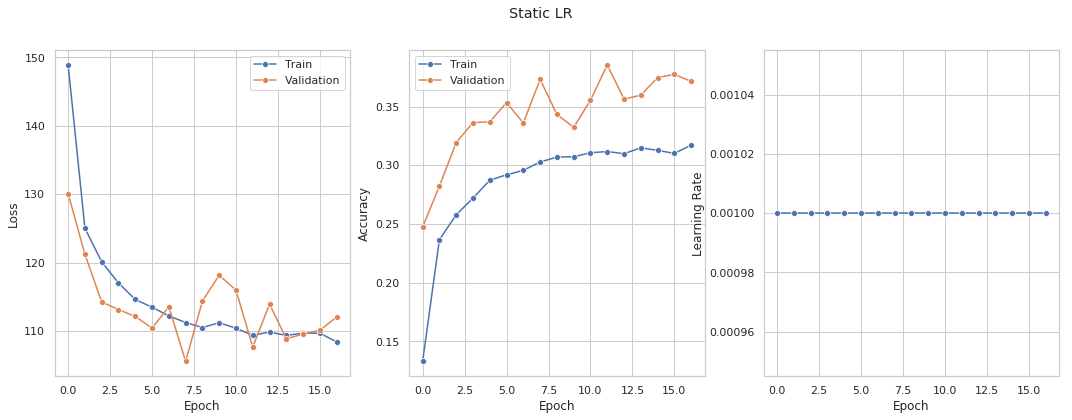

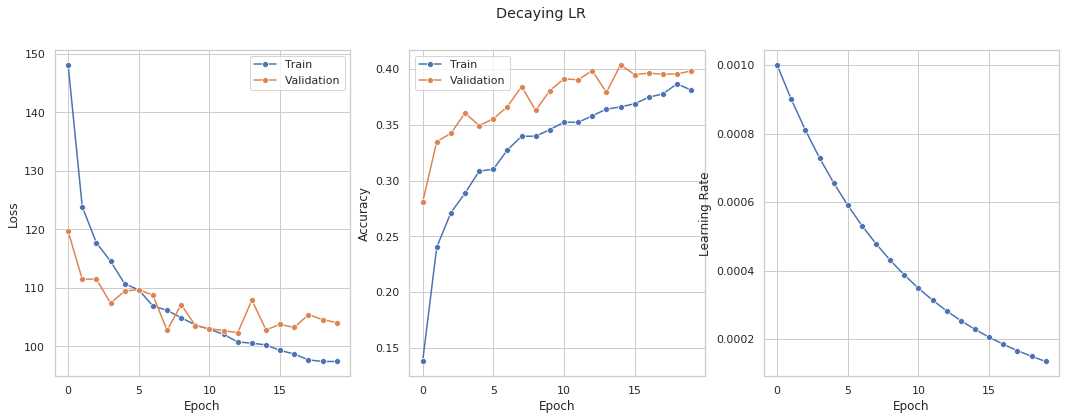

In [19]:
plot_metrics(history_flat, 'Static LR')
plot_metrics(history_decay, 'Decaying LR')

Success; the accuracy of the train and validation set converge nicely! Overfitting problem as seen during the benchmarks is solved. 

In [20]:
model_flat.save('densenet121_frozen_flat.h5')
model_decay.save('densenet121_frozen_decay.h5')

## Unfreeze and Retrain
* We perform a new training session but unfreeze the last part of the pre-trained weights.
* Again we compare multiple learning rate strategies, this time decaying vs. cyclical.


In [21]:
# we have to adjust this down as not to disturb the pre-trained weights too much
LEARNING_RATE = 1e-5

model_step_2_decay = keras.models.load_model('densenet121_frozen_decay.h5', custom_objects=get_dependencies(get_optimizer()))
model_step_2_cyclical = keras.models.load_model('densenet121_frozen_decay.h5', custom_objects=get_dependencies(get_optimizer()))

model_step_2_decay = unfreeze(model_step_2_decay, 'pool4_pool')
model_step_2_cyclical = unfreeze(model_step_2_cyclical, 'pool4_pool')

In [22]:
history_step_2_decay = model_step_2_decay.fit(
    TRAIN_GENERATOR,
    epochs=EPOCHS,
    validation_data=VALIDATION_GENERATOR, 
    class_weight=get_class_weights(TRAIN_GENERATOR.class_indices),
    verbose=1,
    callbacks=[get_early_stopping(), get_lr_callback('decay')]
)

history_step_2_cyclical = model_step_2_cyclical.fit(
    TRAIN_GENERATOR,
    epochs=EPOCHS,
    validation_data=VALIDATION_GENERATOR, 
    class_weight=get_class_weights(TRAIN_GENERATOR.class_indices),
    verbose=1,
    callbacks=[get_early_stopping(), get_lr_callback('triangle2')]
)

Train for 842 steps, validate for 94 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/999
842/842 [==============================] - 450s 535ms/step - loss: 97.5278 - accuracy: 0.3795 - lr: 1.0000e-05 - val_loss: 95.0602 - val_accuracy: 0.4385 - val_lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 9e-06.
Epoch 2/999
842/842 [==============================] - 446s 529ms/step - loss: 94.4547 - accuracy: 0.3977 - lr: 9.0000e-06 - val_loss: 93.5728 - val_accuracy: 0.4456 - val_lr: 9.0000e-06

Epoch 00003: LearningRateScheduler reducing learning rate to 8.1e-06.
Epoch 3/999
842/842 [==============================] - 446s 530ms/step - loss: 93.6421 - accuracy: 0.4014 - lr: 8.1000e-06 - val_loss: 93.2312 - val_accuracy: 0.4486 - val_lr: 8.1000e-06

Epoch 00004: LearningRateScheduler reducing learning rate to 7.290000000000001e-06.
Epoch 4/999
842/842 [==============================] - 445s 528ms/step - loss: 92.3503 - accuracy: 0.4

## Plot 2

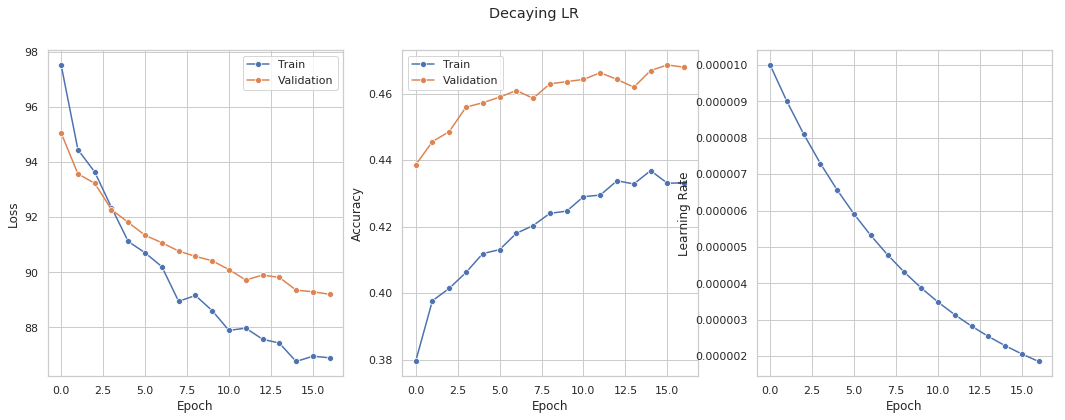

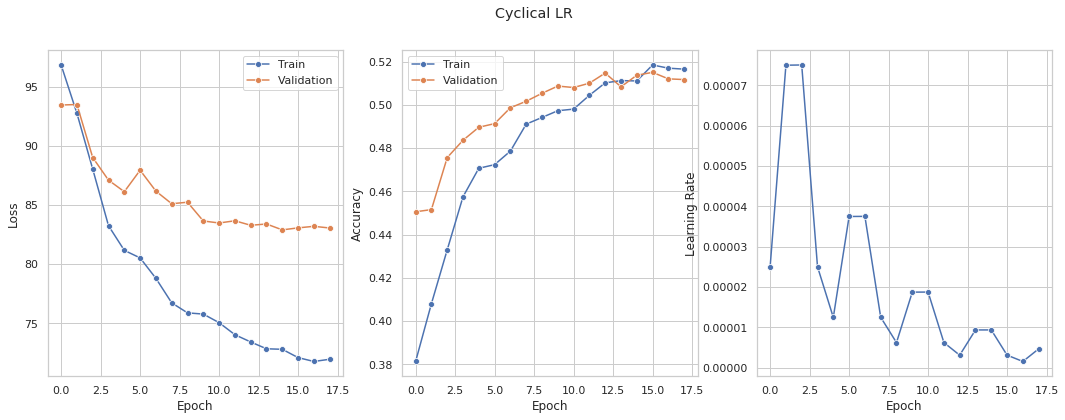

In [23]:
plot_metrics(history_step_2_decay, 'Decaying LR')
plot_metrics(history_step_2_cyclical, 'Cyclical LR')

In [24]:
model_step_2_decay.save('densenet121_unfrozen_decay.h5')
model_step_2_cyclical.save('densenet121_unfrozen_cyclical.h5')

## Predict

In [25]:
model = keras.models.load_model('densenet121_unfrozen_cyclical.h5', custom_objects=get_dependencies(get_optimizer()))

In [26]:
BATCH_SIZE = 1

TEST_GENERATOR = get_generator_dir(DIR + 'test_set/', shuffle=False)

prob_matrix = model.predict(TEST_GENERATOR, verbose=1)

Found 7653 images belonging to 1 classes.
7653/7653 [==============================] - 156s 20ms/step


In [27]:
# get class with the highest confidence
predicted_class_indices = np.argmax(prob_matrix, axis=1)

# map them properly to the filenames since keras orders them alphabetically...
label_map = sorted(TRAIN_GENERATOR.class_indices)
predictions = [label_map[idx] for idx in predicted_class_indices]

# generate submission.csv file
filenames = []
for filename in TEST_GENERATOR.filenames:
    filenames.append(filename[9:]) # strip first part of path ('test_set/')
submission = pd.DataFrame({"img_name": filenames, "label": predictions})
submission.set_index('img_name', inplace=True)
submission.to_csv('submission.csv')